In [1]:
import tensorflow as tf

In [66]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image

import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')

In [114]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
style_path = tf.keras.utils.get_file('-1.jpg','https://mblogthumb-phinf.pstatic.net/20160417_31/sozoh2_14608211810166WLJ0_JPEG/-1.jpg?type=w2')

img = tf.io.read_file(content_path)# binary형태로 불러옴.
img = tf.image.decode_image(img, channels=3)# numpy format으로 변경
img = tf.image.convert_image_dtype(img, tf.float32)# 간혹 0일경우 버그가 발생하므로, float32로 초기화


# 이미지 불러오기
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

# 이미지 출력
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

# tensor포맷을 이미지로?
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)


def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)


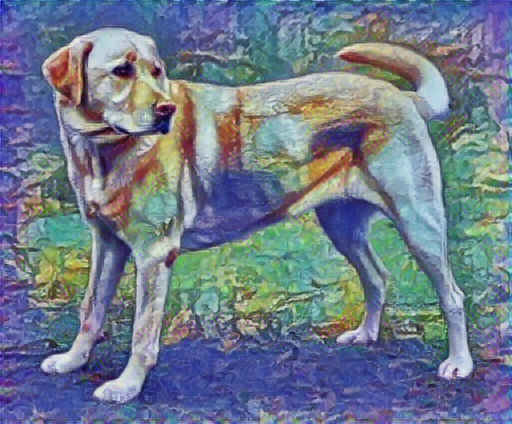

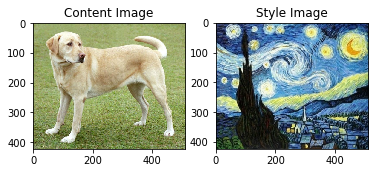

In [115]:
content_image = load_img(content_path)

style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')


stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [116]:
from tensorflow.keras.applications import VGG19

In [117]:
# 1. preprocessing
x = tf.keras.applications.vgg19.preprocess_input(content_image * 255)
x = tf.image.resize(x, (224, 224))

# 2. instance model
model = VGG19(include_top=True)(x)


In [118]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(model.numpy())[0]

In [119]:
predicted_top_5

[('n02099712', 'Labrador_retriever', 0.49317262),
 ('n02099601', 'golden_retriever', 0.23665187),
 ('n02104029', 'kuvasz', 0.036357313),
 ('n02099849', 'Chesapeake_Bay_retriever', 0.024182774),
 ('n02107574', 'Greater_Swiss_Mountain_dog', 0.018646035)]

In [120]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
# vgg.summary() 

In [121]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


In [122]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}


In [123]:
import tensorflow as tf

In [124]:
x = tf.ones((2, 2))

with tf.GradientTape() as t:
  t.watch(x) # x를 상수로서가 아닌, 변수처럼 사용할 수 있게해줌. why?  상수를 미분할 경우 0이 되어버리기때문
  y = tf.reduce_sum(x)
  z = tf.multiply(y, y)

# 입력 텐서 x에 대한 z의 도함수
dz_dx = t.gradient(z, x)
for i in [0, 1]:
  for j in [0, 1]:
    assert dz_dx[i][j].numpy() == 8.0


In [125]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']


In [127]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)


In [128]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


In [129]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)


In [130]:
style_weight=1e-2
content_weight=1e4


In [131]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss


In [132]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))


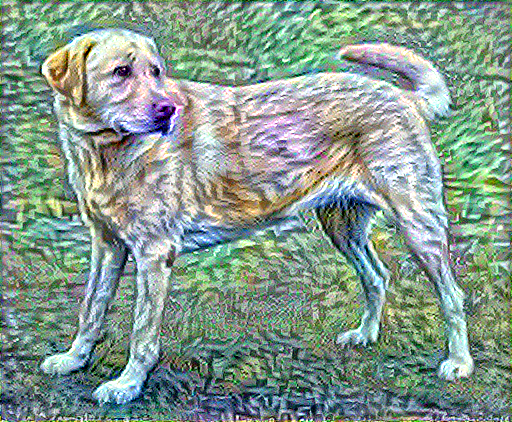

In [166]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)
